# Hierarchical Modeling
What models fit the data?

# Setup

### Imports

In [1]:
# Calculation imports
import cmdstanpy
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm, binned_statistic
from sklearn.metrics import root_mean_squared_error
import sklearn.metrics as sk_metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from tqdm import tqdm

In [2]:
# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

### Parameters

In [3]:
config = {
    "bins": 16,
    "min_bin_percentile": 10,
    "eval_sample_size": 1000,
    "nonden_fit_cols": ["references", "year"],
    "cat_col": "stan_field_code",
}

In [4]:
palette = sns.color_palette()

In [5]:
def log_sum_exp(mu):
    """Calculate the log sum of exponentials
    (pulling out the max to maintain) precision.
    """
    mu_max = np.max(mu)

    summation = np.sum(np.exp(mu - mu_max))
    return mu_max + np.log(summation)

In [6]:
def log_ppd(log_p):
    M = len(log_p)
    return -np.log(M) + log_sum_exp(log_p)

### Load data

In [7]:
df_all = pd.read_csv("../../analysis_data/all_data.csv")
df_all

,density,edginess,references,citations_per_year,is_center,identifier,year,librarian,vectorizer,center,fields_of_study_0
0,1545.550332,0.814415,42,2.250000,False,2e5f3e6c87d1676cdeffc3a2bfbc30b6cd06ed6f,2004,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
1,1846.261870,0.452021,88,4.625000,False,d7b6cd39dd111afa55a3aa418b7b5459db12988d,2012,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
2,1703.520959,0.490212,30,0.882353,False,2d62ec65f95435c72ef750b3cff331382c5dca92,2003,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
3,1901.386693,0.715160,95,8.166667,False,8cebc6e3dcfb543bad48d89112e281a6e11c33c2,2014,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
4,535.472125,0.885892,94,2.090909,False,59730a4bae4dc53f59341b63fd1e63451c589e9f,2009,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
...,...,...,...,...,...,...,...,...,...,...,...
537685,48.730838,0.658585,41,3.500000,False,806f77ba7bdf8a3b80cb859fb5f33f57c1d85d24,2018,S2,SciBERT,Andre2018,Mathematics
537686,25.107589,0.721374,38,3.200000,False,f40707d1165c22e185c25e6837977177ee380f2c,2015,S2,SciBERT,Andre2018,Mathematics
537687,41.647954,0.646499,11,1.529412,False,10636ee16779a7521001651164acb5c192d4ad7b,2003,S2,SciBERT,Andre2018,Mathematics
537688,35.738649,0.708053,15,2.384615,False,a229f829e0a5362d00e63781f687f40ede991635,2007,S2,SciBERT,Andre2018,Mathematics


In [8]:
# Basic nan handling across all obs
df_all["log_cpy"] = np.log10(df_all["citations_per_year"])
df_all["log_cpy"] = df_all["log_cpy"].replace(-np.inf, np.nan)

/Users/zhafen/miniconda3/envs/cmdstan/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
# Make the field category more useful
df_all["fields_of_study_0"] = df_all["fields_of_study_0"].astype("category")
df_all["stan_field_code"] = df_all["fields_of_study_0"].cat.codes + 1
field_names = df_all["fields_of_study_0"].cat.categories
field_names

Index(['Economics', 'Education', 'Geology', 'Linguistics', 'Materials Science',
       'Mathematics', 'Medicine', 'Philosophy', 'Physics'],
      dtype='object')

In [10]:
vectorizer_names = sorted(df_all["vectorizer"].unique())
vectorizer_names

['BOW', 'GPT2', 'SBERT', 'SciBERT', 'Word2Vec']

# Visual Overview

### Brief aside on logscale plotting

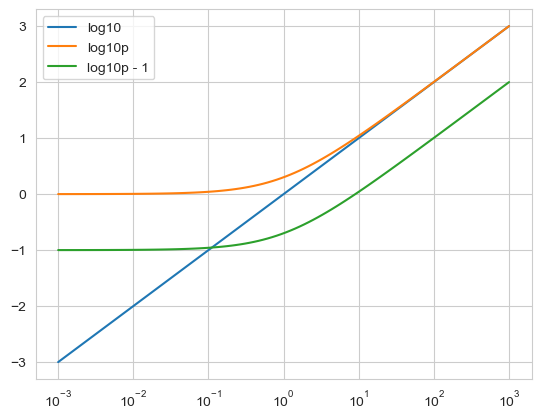

In [11]:
fig = plt.figure()
ax = plt.gca()

x = np.logspace(-3, 3, 100)
log10 = np.log10(x)
log10p = np.log10(1 + x)
log10p2 = np.log10(1 + x) - 1

ax.plot(
    x,
    log10,
    label="log10",
)
ax.plot(
    x,
    log10p,
    label="log10p",
)
ax.plot(
    x,
    log10p2,
    label="log10p - 1",
)

ax.legend()

ax.set_xscale("log")

### Overview Normalized 2D Histogram

In [12]:
def get_bins(x, n_bins=config["bins"]):
    # Get density bins
    bins = np.linspace(
        np.nanpercentile(x, config["min_bin_percentile"]),
        np.nanpercentile(x, 100 - config["min_bin_percentile"]),
        n_bins + 1,
    )
    return bins


density_bins = df_all.groupby("vectorizer")["density"].apply(get_bins).to_dict()
cpy_bins = get_bins(
    df_all["log_cpy"], n_bins=17
)  # The n_bins=17 is to ensure we don't accidentally flip axes

In [13]:
def custom_histplot(data, x, y, normed=True, *args, **kwargs):

    # Get the appropriate facets
    vectorizer = data["vectorizer"].unique()[0]
    field = data["fields_of_study_0"].unique()[0]

    density_bins = get_bins(data[x])

    if normed:
        hist2d, _, _ = np.histogram2d(data[x], data[y], bins=(density_bins, cpy_bins))
        density_hist, _ = np.histogram(data[x], bins=density_bins)
        hist2d_normed = hist2d / density_hist.reshape(1, -1).T

        # Plot the data
        plt.pcolormesh(
            density_bins,
            cpy_bins,
            hist2d_normed.T,
            shading="auto",
            cmap="viridis",
        )
    else:
        sns.histplot(data, x=x, y=y, bins=(density_bins, cpy_bins), *args, **kwargs)

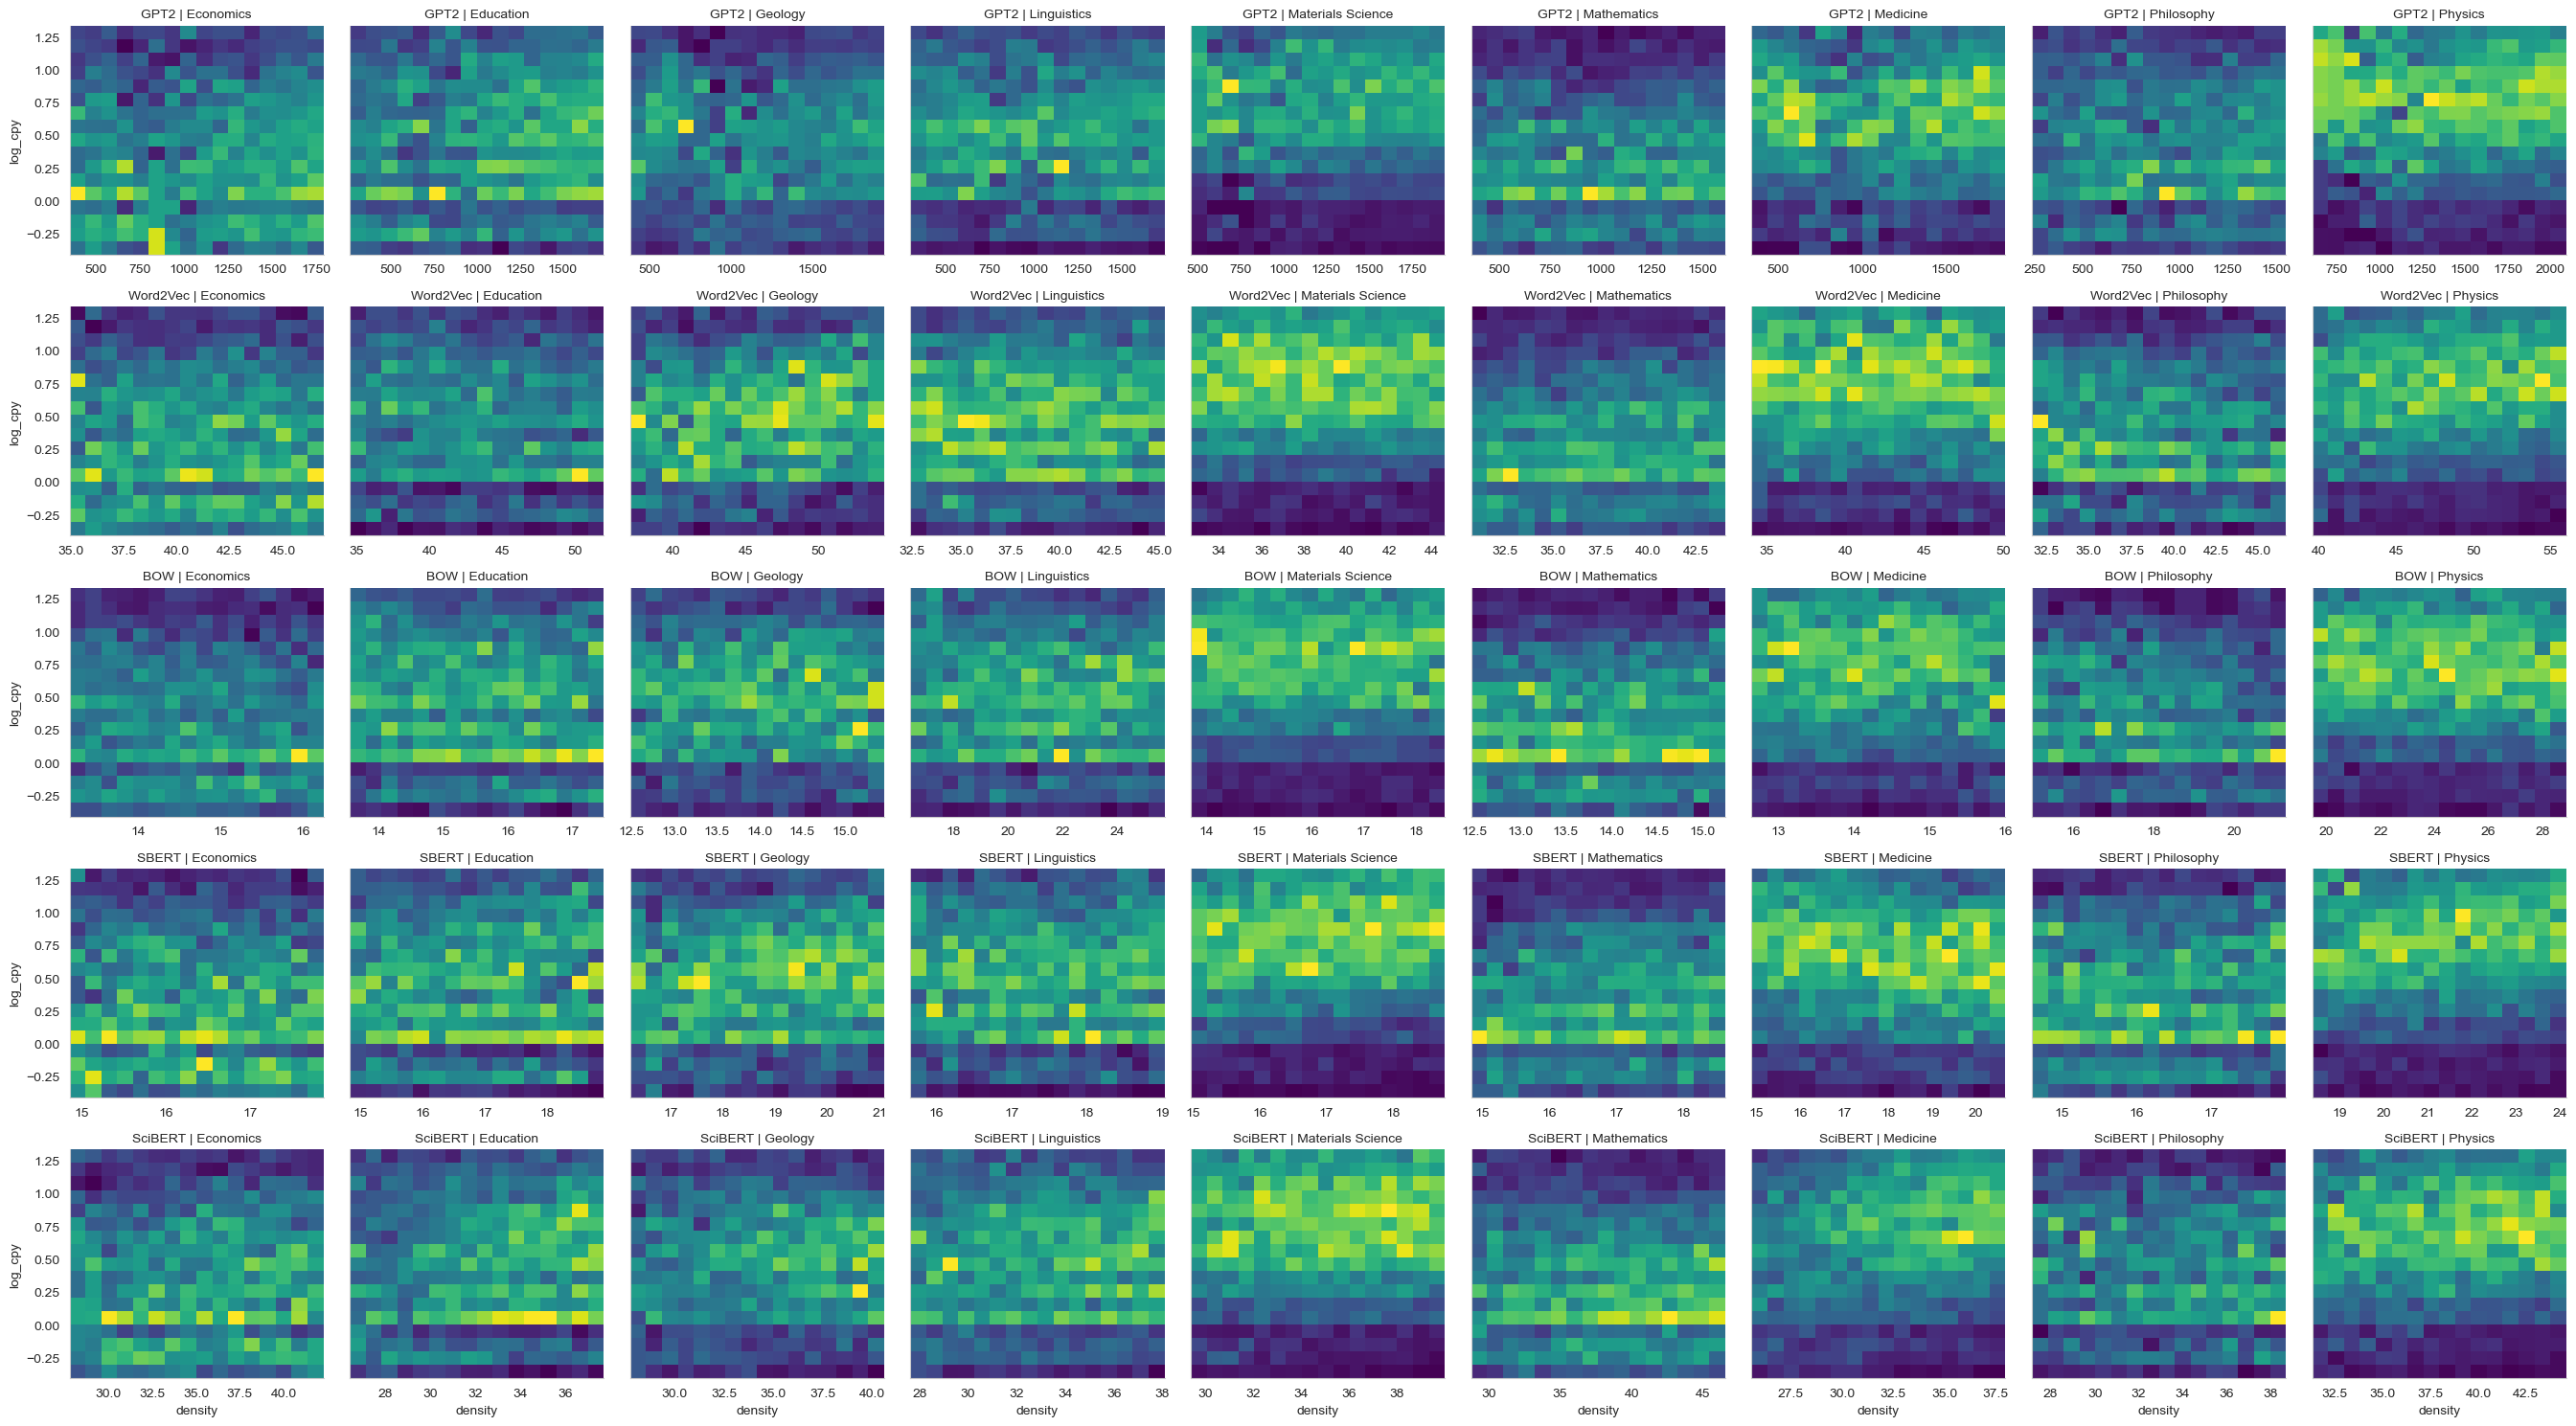

In [14]:
fg = sns.FacetGrid(data=df_all, row="vectorizer", col="fields_of_study_0", sharex=False)
fg.map_dataframe(custom_histplot, x="density", y="log_cpy", normed=True)
fg.set_titles("{row_name} | {col_name}")

### Focused Normalized Histogram

In [15]:
df = df_all.query("vectorizer in ['SciBERT', 'Word2Vec']")

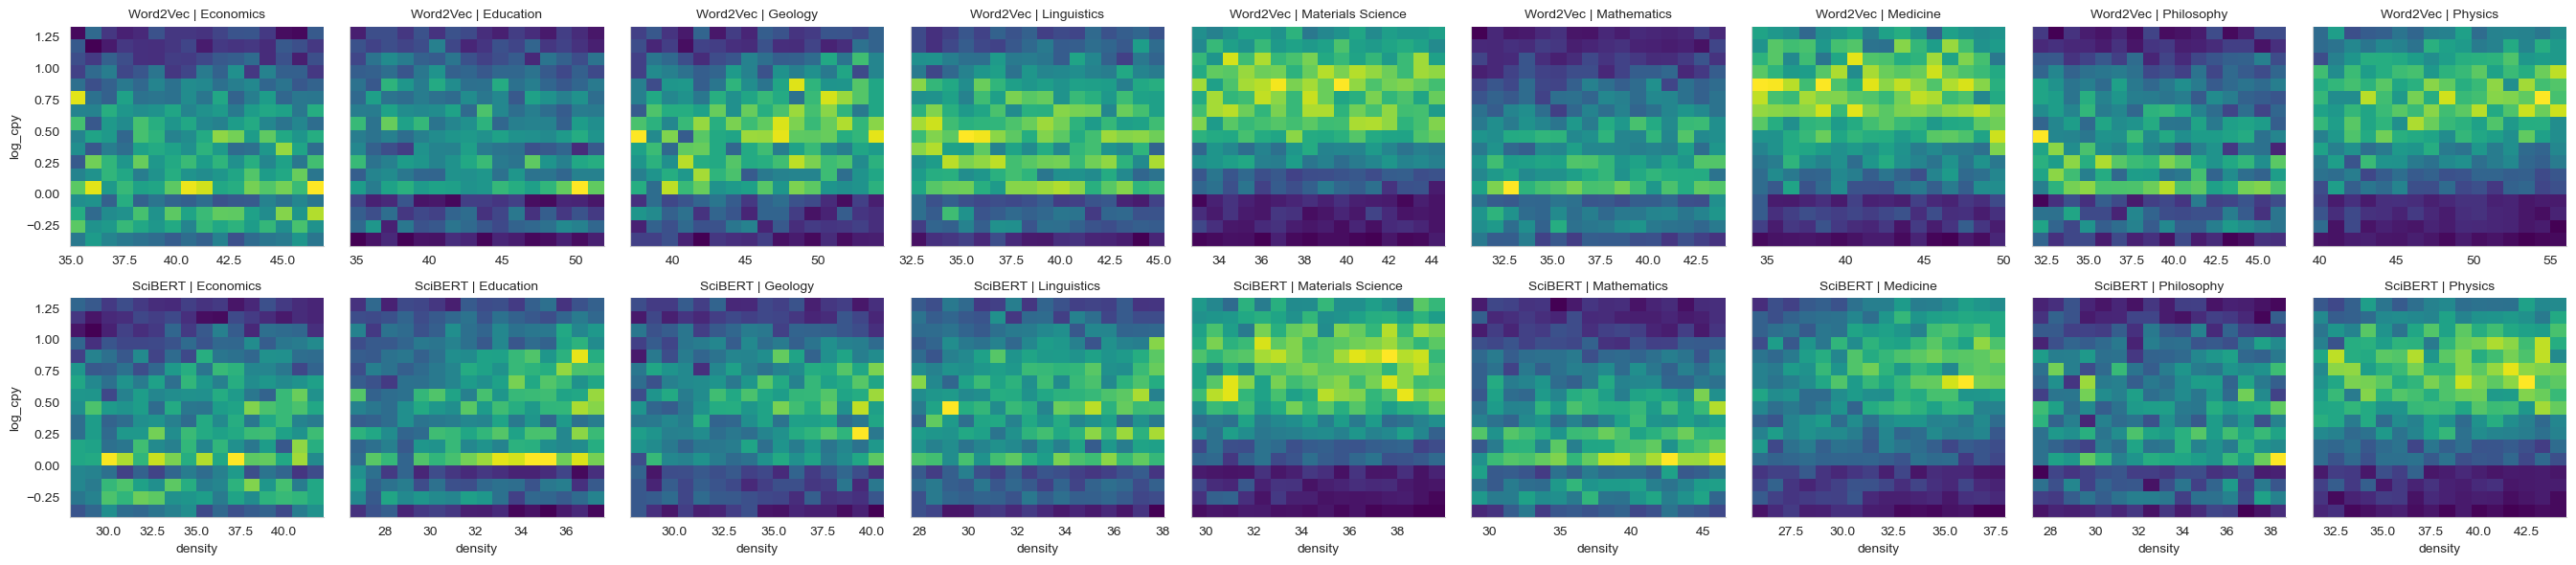

In [16]:
fg = sns.FacetGrid(data=df, row="vectorizer", col="fields_of_study_0", sharex=False)
fg.map_dataframe(custom_histplot, x="density", y="log_cpy", normed=True)
fg.set_titles("{row_name} | {col_name}")

# Statistical Modeling

Note to future self: cmdstanpy and cmdstan advertise conda as *the* way to install.
Don't listen to them.
I couldn't get it to compile when I used conda for anything cmdstanpy related.
I downloaded the repo and compiled manually, and used pip for cmdstanpy.

## Train-Test Split

In [17]:
# Pivot to wide format so we can use the same train_test division
# and so we can use multiple densities at once
df_vectorizers = df_all.pivot_table(
    index="identifier", columns="vectorizer", values="density"
)
# For the nonden cols we can take the first because the other values are duplicates
nonden_cols = [
    "log_cpy",
    config["cat_col"],
] + config["nonden_fit_cols"]
df_others = df_all.groupby("identifier")[nonden_cols].first()
df_eval = pd.concat([df_others, df_vectorizers], axis="columns")
df_eval

,log_cpy,stan_field_code,references,year,BOW,GPT2,SBERT,SciBERT,Word2Vec
identifier,,,,,,,,,
000018fc6887cfb1fe43024b111cbfb4e21bac86,0.816610,9,153,2011,20.247480,NaN,NaN,40.709152,48.709426
00012cd6c267ec07566e9298ad5d689462133f98,-0.176091,1,81,2014,16.675367,1821.844826,17.195921,44.223053,46.829885
00015dd1433923dfaecd815a5610b7e02a240bf1,-1.176091,8,5,2005,NaN,NaN,15.303556,NaN,NaN
0001915f25724aabd56021ad216db4657b544bec,0.449093,2,15,2004,15.214642,1474.294829,15.101694,38.331719,36.408183
00019656527337df9943eb8fd5fe10035c216630,0.896251,7,38,2012,NaN,1824.667374,19.787877,NaN,NaN
...,...,...,...,...,...,...,...,...,...
fffd040a476ea5d68014a0c2d29c132bcfa5c281,0.753328,8,39,2014,16.932139,1357.686408,15.175140,34.163358,42.351464
fffdae38cfe952ec7fc4da420d8ad26a06384d9f,-0.447158,1,21,2006,NaN,NaN,17.679814,NaN,NaN
ffff5e6feb617a8cbc7867f2ef0d3422e6107697,0.946125,7,43,2002,13.273726,1656.083989,15.323810,29.493443,39.875730


In [18]:
# Drop all columns where log_cpy is na
df_eval = df_eval.dropna(subset="log_cpy")

In [19]:
# Apply scaling (normalization by mean and sigma) to help with modelling
scaled_cols = (
    [
        "log_cpy",
    ]
    + config["nonden_fit_cols"]
    + vectorizer_names
)
df_eval.loc[:, scaled_cols] = df_eval[scaled_cols].apply(scale)
df_eval

/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_5845/787321112.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.29427405  0.36043231 -0.62528953 ... -0.41776914 -0.13242861
 -0.19727873]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_eval.loc[:, scaled_cols] = df_eval[scaled_cols].apply(scale)
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_5845/787321112.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.059374    0.52071293 -1.21954787 ... -1.02618556 -1.7996348
  0.13398831]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_eval.loc[:, scaled_cols] = df_eval[scaled_cols].apply(scale)


,log_cpy,stan_field_code,references,year,BOW,GPT2,SBERT,SciBERT,Word2Vec
identifier,,,,,,,,,
000018fc6887cfb1fe43024b111cbfb4e21bac86,0.443906,9,1.294274,-0.059374,0.851130,NaN,NaN,0.994016,1.026570
00012cd6c267ec07566e9298ad5d689462133f98,-1.024292,1,0.360432,0.520713,-0.029242,1.027300,-0.092462,1.589500,0.758595
00015dd1433923dfaecd815a5610b7e02a240bf1,-2.503285,8,-0.625290,-1.219548,NaN,NaN,-0.493021,NaN,NaN
0001915f25724aabd56021ad216db4657b544bec,-0.099649,2,-0.495589,-1.412910,-0.389248,0.418554,-0.535749,0.591124,-0.727279
00019656527337df9943eb8fd5fe10035c216630,0.561694,7,-0.197279,0.133988,NaN,1.032243,0.456179,NaN,NaN
...,...,...,...,...,...,...,...,...,...
fffcfbd21e584fa023c51f2b5b813c8914a7659a,0.591575,3,-0.430739,-0.639461,NaN,NaN,-0.172983,NaN,NaN
fffd040a476ea5d68014a0c2d29c132bcfa5c281,0.350312,8,-0.184309,0.520713,0.034041,0.214311,-0.520202,-0.115268,0.120084
fffdae38cfe952ec7fc4da420d8ad26a06384d9f,-1.425198,1,-0.417769,-1.026186,NaN,NaN,0.009964,NaN,NaN


In [20]:
# Downsample
if config["eval_sample_size"] is not None:
    df_eval = df_eval.sample(config["eval_sample_size"])

In [21]:
# Train-test split
df_train, df_test = train_test_split(df_eval)

In [22]:
# dictionary to store results in
results_dict = {}

## Base model
The base model is just a normal distribution.

In [23]:
stan_model = "base"

In [24]:
# Dict for storing output
output = {}

In [25]:
# Drop na
df_train_i = df_train.dropna(subset=["log_cpy"])
df_test_i = df_train.dropna(subset=["log_cpy"])

In [26]:
# Format data
data = {
    "N": len(df_train_i),
    "y": df_train_i["log_cpy"].values,
    "N_test": len(df_test_i),
    "y_test": df_test_i["log_cpy"].values,
}

In [27]:
# Compile model
model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

In [28]:
# Fit model
fit = model.sample(
    data=data,
)

17:00:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:00:06 - cmdstanpy - INFO - CmdStan done processing.
17:00:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'base.stan', line 13, column 4 to column 29)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'base.stan', line 13, column 4 to column 29)
Consider re-running with show_console=True if the above output is unclear!


In [29]:
# Parse output
draws = fit.draws_pd()

In [30]:
# Store parameters
output["alpha"] = draws["alpha"].median()
output["sigma"] = draws["sigma"].median()

In [31]:
# Calculate log posterior predictive density
output["log_ppd"] = log_ppd(draws["log_p"])

In [32]:
results_dict[stan_model] = pd.Series(output)

## Linear regression on density
$(c \sim \rho_t)$ vs $(c \sim \rho_v)$

In [33]:
stan_model = "reg"

### Fit

In [34]:
# Dictionary to hold modeling output

# Loop through vectorizers
outputs_for_this_model = {}
for i, vectorizer_i in enumerate(vectorizer_names):
    output = {}

    # Drop na
    df_train_i = df_train.dropna(subset=[vectorizer_i, "log_cpy"])
    df_test_i = df_train.dropna(subset=[vectorizer_i, "log_cpy"])

    # Format data
    data = {
        "N": len(df_train_i),
        "x": df_train_i[vectorizer_i].values,
        "y": df_train_i["log_cpy"].values,
        "N_test": len(df_test_i),
        "x_test": df_test_i[vectorizer_i].values,
        "y_test": df_test_i["log_cpy"].values,
    }

    # Compile model
    model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

    # Fit model
    fit = model.sample(
        data=data,
    )

    # Parse output
    draws = fit.draws_pd()

    # Store parameters
    output["alpha"] = draws["alpha"].median()
    output[f"beta[{vectorizer_i}]"] = draws["beta"].median()
    output["sigma"] = draws["sigma"].median()

    # Calculate log posterior predictive density
    output["log_ppd"] = log_ppd(draws["log_p"])

    key = f"{stan_model}_{vectorizer_i}"
    outputs_for_this_model[key] = output
    results_dict[key] = output

17:00:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:00:07 - cmdstanpy - INFO - CmdStan done processing.
17:00:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
Consider re-running with show_console=True if the above output is unclear!
17:00:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:00:07 - cmdstanpy - INFO - CmdStan done processing.
17:00:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:00:08 - cmdstanpy - INFO - CmdStan done processing.
17:00:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
Consider re-running with show_console=True if the above output is unclear!


17:00:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:00:08 - cmdstanpy - INFO - CmdStan done processing.
17:00:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
Consider re-running with show_console=True if the above output is unclear!


17:00:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:00:09 - cmdstanpy - INFO - CmdStan done processing.
17:00:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
Consider re-running with show_console=True if the above output is unclear!


### Evaluate

In [35]:
# Format for showing here
output = pd.DataFrame(outputs_for_this_model).T
output["vectorizer"] = vectorizer_names

In [36]:
def medianplot(data, x, y, bins, ax):

    x = data[x]
    y = data[y]

    centers = (bins[1:] + bins[:-1]) / 2

    # Calculate running median
    median, bin_edges, bin_number = binned_statistic(
        x, y, statistic=np.nanmedian, bins=bins
    )
    ax.plot(
        centers,
        median,
        color="k",
    )

    # Calculate running percentiles
    low, bin_edges, bin_number = binned_statistic(
        x,
        y,
        statistic=lambda v: np.nanpercentile(v, 16),
        bins=bins,
    )
    high, bin_edges, bin_number = binned_statistic(
        x,
        y,
        statistic=lambda v: np.nanpercentile(v, 84),
        bins=bins,
    )
    ax.fill_between(
        centers,
        low,
        high,
        color="k",
        alpha=0.1,
    )

    ax.set_xlim(bins[0], bins[-1])

In [37]:
left_edge = np.nanpercentile(
    df_eval[vectorizer_names].values.flatten(), config["min_bin_percentile"]
)
right_edge = -left_edge
bins = np.linspace(left_edge, right_edge, config["bins"])

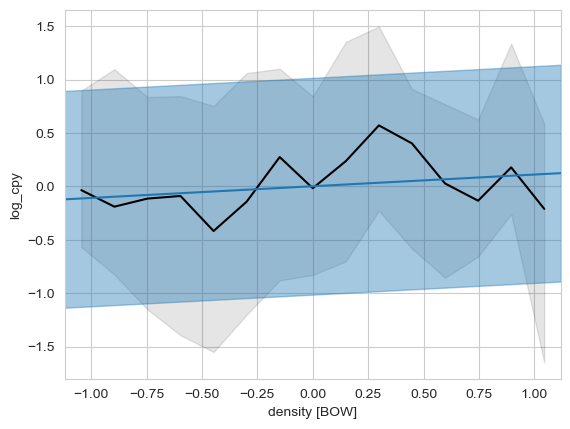

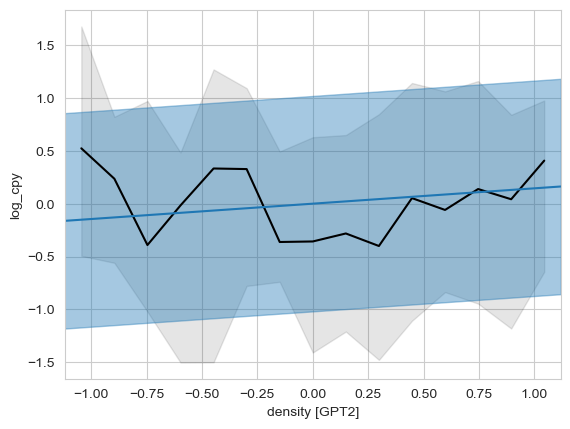

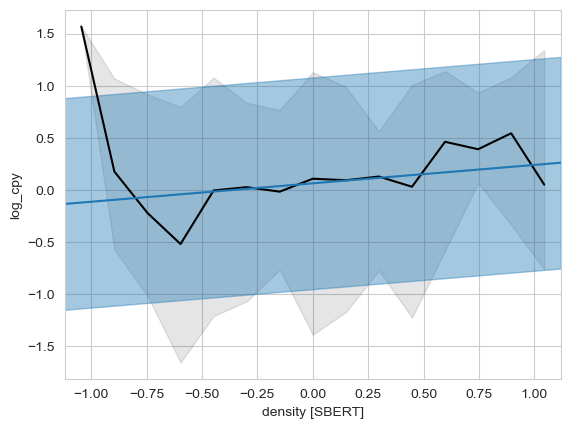

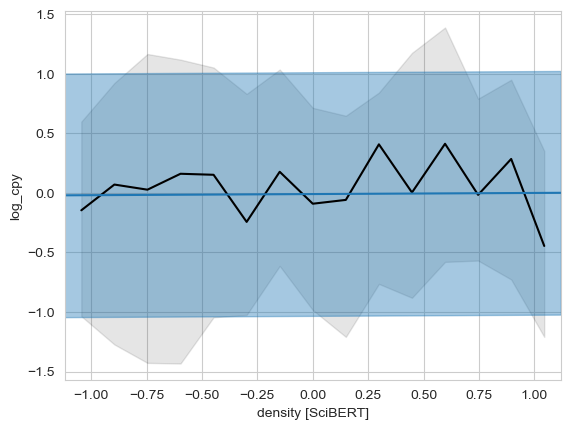

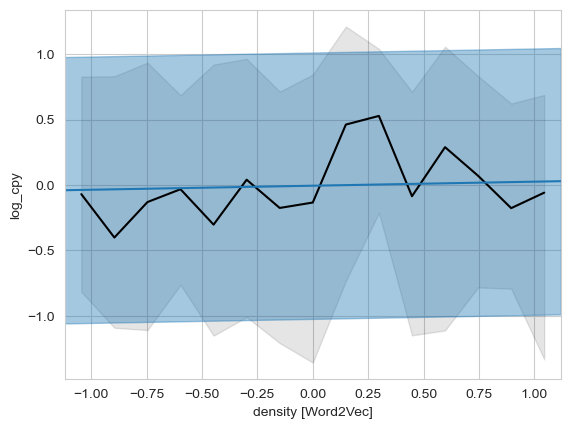

In [38]:
for i, row in output.iterrows():
    fig = plt.figure()
    ax = plt.gca()

    df_plot = df_eval.dropna(subset=[row["vectorizer"], "log_cpy"])

    medianplot(
        data=df_plot,
        x=row["vectorizer"],
        y="log_cpy",
        bins=bins,
        ax=ax,
    )

    # Plot the regression
    xs = bins
    ys = row["alpha"] + row[f"beta[{row["vectorizer"]}]"] * xs
    ax.plot(
        xs,
        ys,
        color=palette[0],
    )
    ax.fill_between(
        xs,
        ys - row["sigma"],
        ys + row["sigma"],
        color=palette[0],
        alpha=0.4,
    )

    ax.set_xlabel(f"density [{row["vectorizer"]}]")
    ax.set_ylabel("log_cpy")

    

## Multivariate linear regression w/o density
The next model is a multivate linear regression with no density

In [39]:
stan_model = "multireg"
fit_cols = config["nonden_fit_cols"]
cols = [
    "log_cpy",
] + fit_cols

In [40]:
# Dict for storing output
output = {}

In [41]:
# Drop na
df_train_i = df_train[cols].dropna()
df_test_i = df_train[cols].dropna()

In [42]:
# Format data
data = {
    "N": len(df_train_i),
    "K": len(fit_cols),
    "x": df_train_i[fit_cols].values,
    "y": df_train_i["log_cpy"].values,
    "N_test": len(df_test_i),
    "x_test": df_test_i[fit_cols].values,
    "y_test": df_test_i["log_cpy"].values,
}

In [43]:
# Compile model
model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

In [44]:
# Fit model
fit = model.sample(
    data=data,
)

17:00:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:00:11 - cmdstanpy - INFO - CmdStan done processing.
17:00:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Consider re-running with show_console=True if the above output is unclear!


In [45]:
# Parse output
draws = fit.draws_pd()

In [46]:
# Store parameters
output["alpha"] = draws["alpha"].median()
output["sigma"] = draws["sigma"].median()
beta_cols = [col for col in draws.columns if col[:4] == "beta"]
betas = draws[beta_cols].median(axis="rows")
for i, fit_col in enumerate(fit_cols):
    output[f"beta[{fit_col}]"] = betas.iloc[i]

In [47]:
# Calculate log posterior predictive density
output["log_ppd"] = log_ppd(draws["log_p"])

In [48]:
results_dict[stan_model] = pd.Series(output)

## Multivariate linear regression
Now with density.

In [49]:
stan_model = "multireg"

In [50]:
# Dictionary to hold modeling output

# Loop through vectorizers
outputs_for_this_model = {}
for i, vectorizer_i in enumerate(vectorizer_names):
    output = {}

    # Drop na
    fit_cols = [
        vectorizer_i,
    ] + config["nonden_fit_cols"]
    cols = [
        "log_cpy",
    ] + fit_cols
    df_train_i = df_train.dropna(subset=cols)
    df_test_i = df_train.dropna(subset=cols)

    # Format data
    data = {
        "N": len(df_train_i),
        "K": len(fit_cols),
        "x": df_train_i[fit_cols].values,
        "y": df_train_i["log_cpy"].values,
        "N_test": len(df_test_i),
        "x_test": df_test_i[fit_cols].values,
        "y_test": df_test_i["log_cpy"].values,
    }

    # Compile model
    model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

    # Fit model
    fit = model.sample(
        data=data,
    )

    # Parse output
    draws = fit.draws_pd()

    # Store parameters
    output["alpha"] = draws["alpha"].median()
    output["sigma"] = draws["sigma"].median()
    beta_cols = [col for col in draws.columns if col[:4] == "beta"]
    betas = draws[beta_cols].median(axis="rows")
    for i, fit_col in enumerate(fit_cols):
        output[f"beta[{fit_col}]"] = betas.iloc[i]

    # Calculate log posterior predictive density
    output["log_ppd"] = log_ppd(draws["log_p"])

    key = f"{stan_model}_{vectorizer_i}"
    outputs_for_this_model[key] = output
    results_dict[key] = output

17:00:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:00:11 - cmdstanpy - INFO - CmdStan done processing.
17:00:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Consider re-running with show_console=True if the above output is unclear!
17:00:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:00:12 - cmdstanpy - INFO - CmdStan done processing.
17:00:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Consider re-running with show_console=True if the above output is unclear!
17:00:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:00:12 - cmdstanpy - INFO - CmdStan done processing.
17:00:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Consider re-running with show_console=True if the above output is unclear!
17:00:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:00:13 - cmdstanpy - INFO - CmdStan done processing.
17:00:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:00:13 - cmdstanpy - INFO - CmdStan done processing.
17:00:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Consider re-running with show_console=True if the above output is unclear!


## Multivariate linear regression w/ all fields
The next model is a multivate linear regression using every variable we have

In [51]:
stan_model = "multireg"
fit_cols = config["nonden_fit_cols"] + vectorizer_names
cols = [
    "log_cpy",
] + fit_cols

In [52]:
# Dict for storing output
output = {}

In [53]:
# Drop na
df_train_i = df_train[cols].dropna()
df_test_i = df_train[cols].dropna()

In [54]:
# Format data
data = {
    "N": len(df_train_i),
    "K": len(fit_cols),
    "x": df_train_i[fit_cols].values,
    "y": df_train_i["log_cpy"].values,
    "N_test": len(df_test_i),
    "x_test": df_test_i[fit_cols].values,
    "y_test": df_test_i["log_cpy"].values,
}

In [55]:
# Compile model
model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

In [56]:
# Fit model
fit = model.sample(
    data=data,
)

17:00:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:00:14 - cmdstanpy - INFO - CmdStan done processing.


In [57]:
# Parse output
draws = fit.draws_pd()

In [58]:
# Store parameters
output["alpha"] = draws["alpha"].median()
output["sigma"] = draws["sigma"].median()
beta_cols = [col for col in draws.columns if col[:4] == "beta"]
betas = draws[beta_cols].median(axis="rows")
for i, fit_col in enumerate(fit_cols):
    output[f"beta[{fit_col}]"] = betas.iloc[i]

In [59]:
# Calculate log posterior predictive density
output["log_ppd"] = log_ppd(draws["log_p"])

In [60]:
results_dict[f"full_{stan_model}"] = pd.Series(output)

## Hierarchical Linear Regression on density

In [61]:
stan_model = "hreg"

### Fit

In [62]:
# Dictionary to hold modeling output

# Loop through vectorizers
outputs_for_this_model = {}
for i, vectorizer_i in enumerate(vectorizer_names):
    output = {}

    # Drop na
    df_train_i = df_train.dropna(subset=[vectorizer_i, "log_cpy"])
    df_test_i = df_train.dropna(subset=[vectorizer_i, "log_cpy"])

    # Format data
    data = {
        "D": 1,
        "N": len(df_train_i),
        "L": df_train_i[config["cat_col"]].max(),
        "y": df_train_i["log_cpy"].values,
        "ll": df_train_i[config["cat_col"]].values,
        "x": df_train_i[
            [
                vectorizer_i,
            ]
        ].values,
        "N_test": len(df_test_i),
        "x_test": df_test_i[[vectorizer_i]].values,
        "y_test": df_test_i["log_cpy"].values,
    }

    # Compile model
    model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

    # Fit model
    fit = model.sample(
        data=data,
    )

    # Parse output
    stan_vars = fit.stan_variables()

    # Store parameters
    output["alpha"] = np.median(stan_vars["alpha"])
    output["sigma"] = np.median(stan_vars["sigma"])

    # Store per-field betas
    betas = np.nanmedian(stan_vars["beta"], axis=0)
    for i, betas_i in enumerate(betas):
        field_name_i = field_names[i]
        beta_i = betas_i[0]
        output[f"beta[{vectorizer_i},{field_name_i}]"] = beta_i

    # Calculate log posterior predictive density
    output["log_ppd"] = log_ppd(draws["log_p"])

    key = f"{stan_model}_{vectorizer_i}"
    outputs_for_this_model[key] = output
    results_dict[key] = output

17:00:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:00:15 - cmdstanpy - INFO - CmdStan done processing.
17:00:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 32, column 4 to column 26)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 32, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 32, column 4 to column 26)
Consider re-running with show_console=True if the above output is unclear!


17:00:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:00:18 - cmdstanpy - INFO - CmdStan done processing.
17:00:18 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 11 divergent transitions (1.1%)
	Chain 2 had 5 divergent transitions (0.5%)
	Chain 3 had 14 divergent transitions (1.4%)
	Chain 4 had 12 divergent transitions (1.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


17:00:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:00:20 - cmdstanpy - INFO - CmdStan done processing.
17:00:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 32, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 32, column 4 to column 26)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 32, column 4 to column 26)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 32, column 4 to column 26)
Consider re-running with show_console=True if the above output is unclear!
17:00:20 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (0.3%)
	Chain 2 had 6 divergent transitions (0.6%)
	Chain 3 had 3 divergent transitions (0.3%)
	Chain 4 had 2 divergent transitions (0.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


17:00:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:00:22 - cmdstanpy - INFO - CmdStan done processing.
17:00:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 32, column 4 to column 26)
Consider re-running with show_console=True if the above output is unclear!


17:00:22 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (0.3%)
	Chain 2 had 19 divergent transitions (1.9%)
	Chain 3 had 3 divergent transitions (0.3%)
	Chain 4 had 20 divergent transitions (2.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
17:00:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:00:24 - cmdstanpy - INFO - CmdStan done processing.
17:00:24 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Chain 3 had 1 divergent transitions (0.1%)
	Chain 4 had 2 divergent transitions (0.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


### Evaluate

In [63]:
# Format for showing here
output = pd.DataFrame(outputs_for_this_model).T
output["vectorizer"] = vectorizer_names

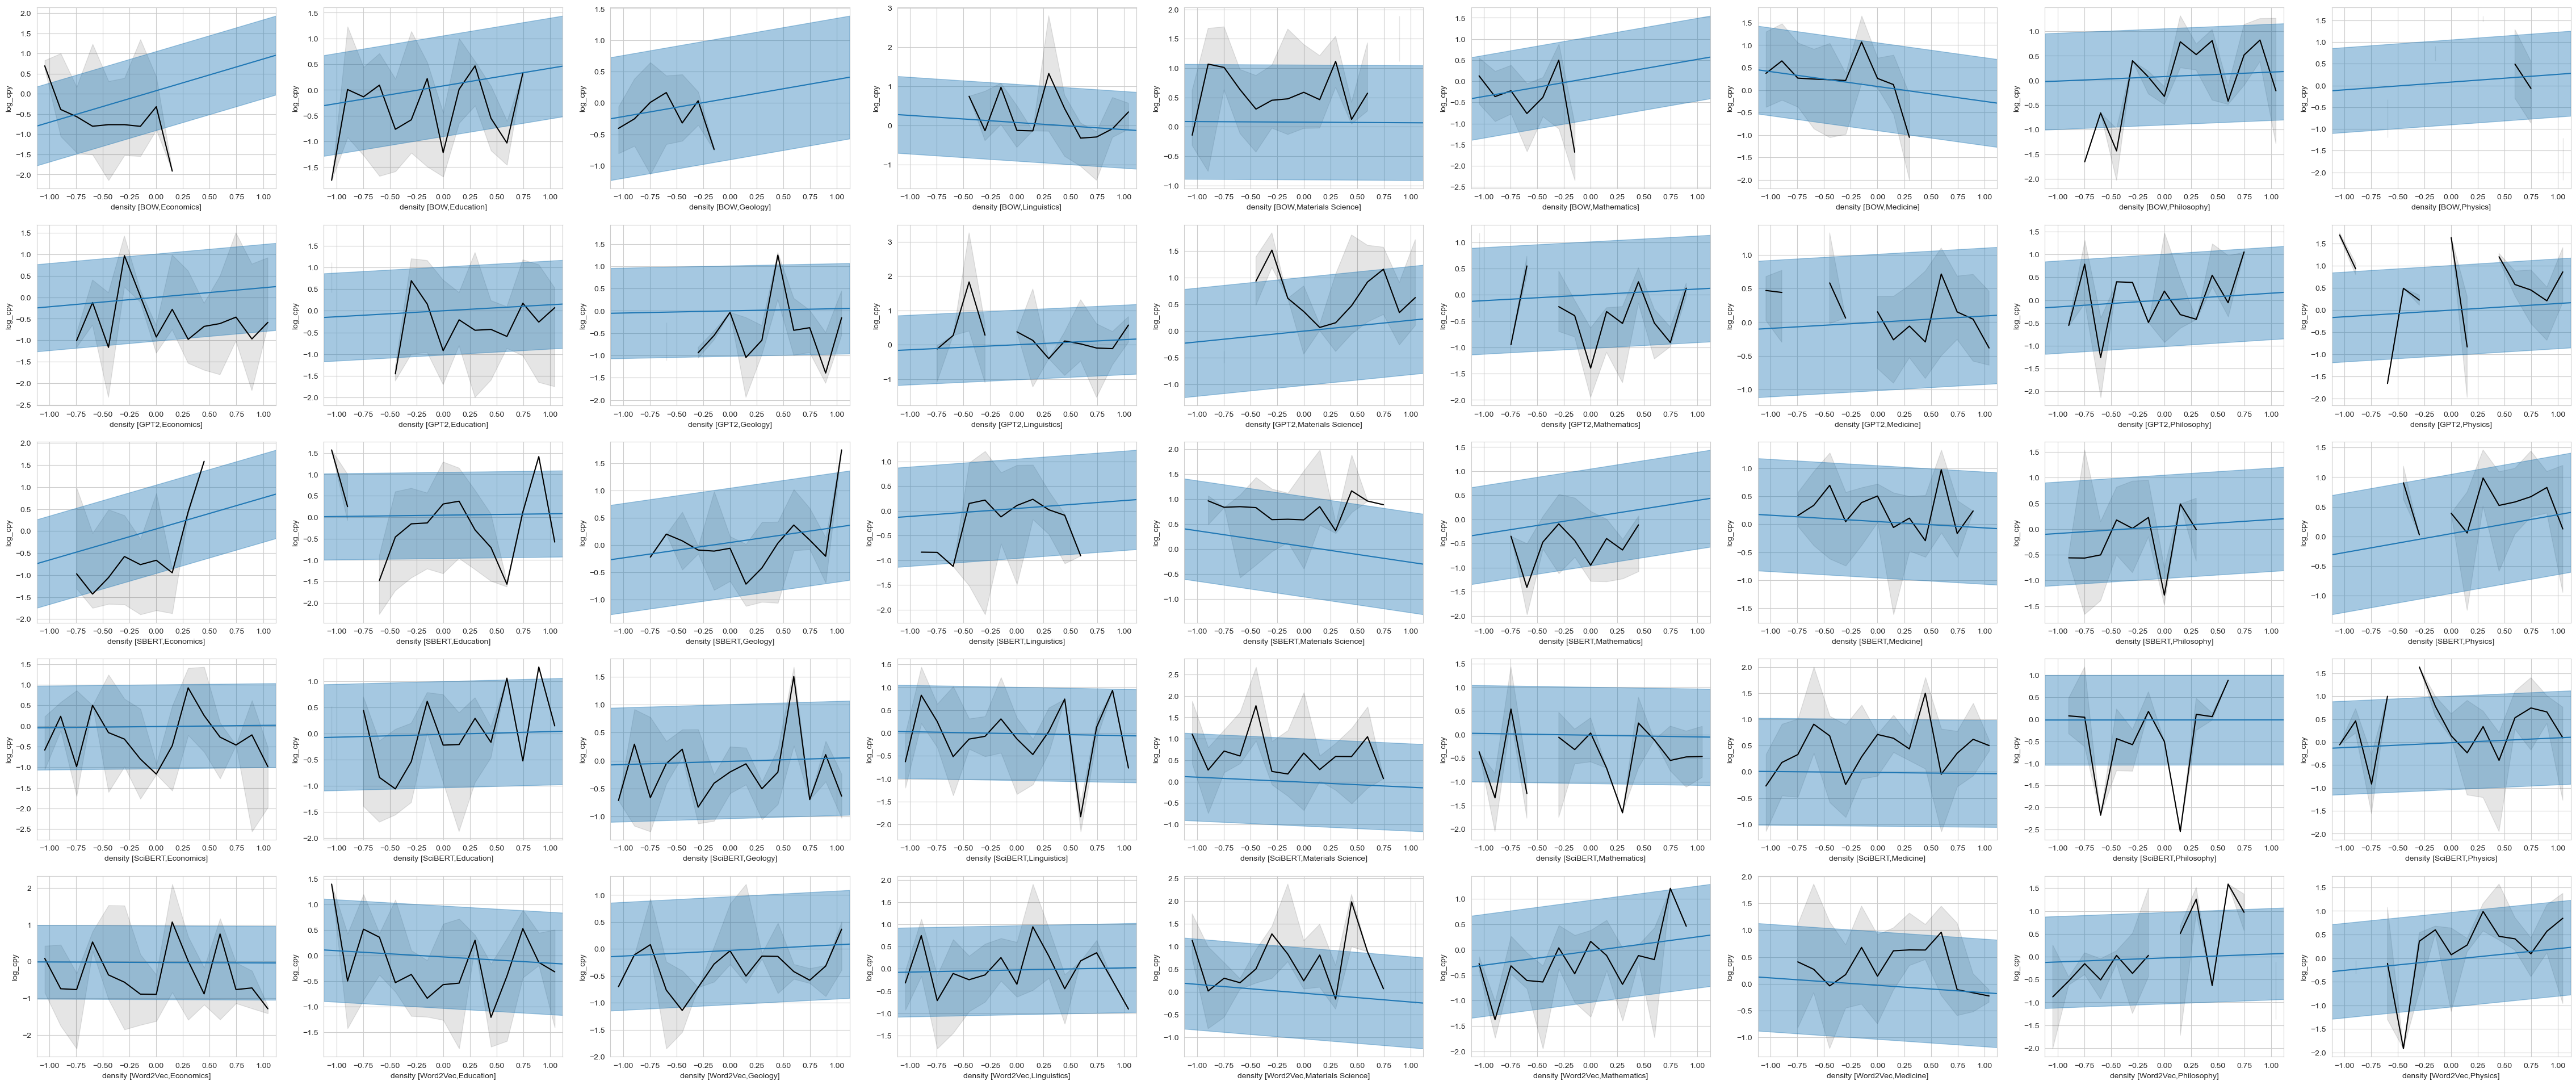

In [64]:
fig = plt.figure(figsize=(6.4 * len(field_names), 4.8 * len(vectorizer_names)))
mosaic = [[f"{vectorizer_i}_{field_j}" for field_j in field_names] for vectorizer_i in vectorizer_names]
ax_dict = fig.subplot_mosaic(mosaic=mosaic)
for i, (model_i, row) in enumerate(output.iterrows()):
    vectorizer_i = row["vectorizer"]
    for j, field_j in enumerate(field_names):

        ax_key = f"{vectorizer_i}_{field_j}" 
        ax = ax_dict[ax_key]

        df_plot = df_eval.query(f"stan_field_code == {j+1}")

        medianplot(
            data=df_plot,
            x=row["vectorizer"],
            y="log_cpy",
            bins=bins,
            ax=ax,
        )

        # Plot the regression
        xs = bins
        ys = row["alpha"] + row[f"beta[{row["vectorizer"]},{field_j}]"] * xs
        ax.plot(
            xs,
            ys,
            color=palette[0],
        )
        ax.fill_between(
            xs,
            ys - row["sigma"],
            ys + row["sigma"],
            color=palette[0],
            alpha=0.4,
        )

        ax.set_xlabel(f"density [{row["vectorizer"]},{field_j}]")
        ax.set_ylabel("log_cpy")


        

# Summarize

In [65]:
results = pd.DataFrame(results_dict).T
results

,alpha,"beta[BOW,Economics]","beta[BOW,Education]","beta[BOW,Geology]","beta[BOW,Linguistics]","beta[BOW,Materials Science]","beta[BOW,Mathematics]","beta[BOW,Medicine]","beta[BOW,Philosophy]","beta[BOW,Physics]",...,"beta[Word2Vec,Materials Science]","beta[Word2Vec,Mathematics]","beta[Word2Vec,Medicine]","beta[Word2Vec,Philosophy]","beta[Word2Vec,Physics]",beta[Word2Vec],beta[references],beta[year],log_ppd,sigma
base,0.039160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1073.901900,1.013570
reg_BOW,0.001644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-750.438114,1.015150
reg_GPT2,0.001141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-771.202539,1.019210
reg_SBERT,0.064324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-762.461793,1.015100
reg_SciBERT,-0.009146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-747.524486,1.023435
reg_Word2Vec,-0.005122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.030909,NaN,NaN,-752.602618,1.019120
multireg,0.037778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.186189,0.151950,-1053.382427,0.986895
multireg_BOW,-0.003378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.204664,0.129949,-735.595181,0.987383
multireg_GPT2,-0.004862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.156010,0.152907,-758.348149,0.995367
multireg_SBERT,0.059607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.149923,0.162448,-750.725115,0.995403


## Calculate y_pred

In [175]:
# Get the test x values
x_test = df_test[fit_cols].fillna(0.0).values

In [176]:
# Get the contribution to y_pred from the intercept
alphas = results["alpha"].values.reshape(1, -1)

In [177]:
# Get the coefficients for regular regression
# and the contribution to y_pred from the regular regression
beta_cols = [f"beta[{fit_col}]" for fit_col in fit_cols]
betas = results[beta_cols].fillna(0.0).values
y_pred_beta = np.matmul(x_test, betas.T)

In [178]:
# Calculate and format y_pred (without the hierarchical reg contribution)
y_pred = alphas + y_pred_beta
y_pred = pd.DataFrame(y_pred, index=df_test.index, columns=results.index)

In [179]:
# Get the contribution to y_pred from hierarchical regression
n_tot = 0
for i, field_name_i in enumerate(field_names):
    # Get the x values
    df_test_i = df_test.query(f"stan_field_code == {i + 1}")
    den_test_i = df_test_i[vectorizer_names].fillna(0.0).values

    # Get the slopes used for this particular field
    beta_cols_i = [
        f"beta[{vectorizer},{field_name_i}]" for vectorizer in vectorizer_names
    ]
    betas_i = results[beta_cols_i].fillna(0.0).values

    # Get y_pred and store it
    y_pred_beta_i = np.matmul(den_test_i, betas_i.T)
    y_pred.loc[df_test_i.index] += y_pred_beta_i

    # Keep track of n_tot as a double check that every observation has a contribution
    # from their primary field
    n_tot += len(y_pred_beta_i)

assert n_tot == len(df_test), "y_pred count doesn't match"

In [180]:
y_pred

,base,reg_BOW,reg_GPT2,reg_SBERT,reg_SciBERT,reg_Word2Vec,multireg,multireg_BOW,multireg_GPT2,multireg_SBERT,multireg_SciBERT,multireg_Word2Vec,full_multireg,hreg_BOW,hreg_GPT2,hreg_SBERT,hreg_SciBERT,hreg_Word2Vec
identifier,,,,,,,,,,,,,,,,,,
15df368fca57a9e0da636e17b42a0e506ef39ebf,0.03916,-0.071035,-0.005958,0.103360,-0.018144,-0.010710,-0.017635,-0.115689,-0.059405,0.019164,-0.045043,-0.065236,0.078856,0.298068,-0.004414,0.022798,0.004509,-0.002747
1325ad1682ed356282dae5c4c382693ccc871142,0.03916,-0.020793,0.066386,0.064324,-0.004564,-0.017276,0.138126,0.071072,0.153135,0.161288,0.064863,0.110895,0.106907,0.060052,0.067938,0.047804,-0.013267,-0.062149
f6c6d291aa4b8f3f661010d1ff3d10e8882aa6c9,0.03916,-0.089647,0.190964,0.064324,-0.015596,-0.001058,0.106330,-0.007490,0.237238,0.127932,0.073006,0.052296,0.326097,-0.167595,0.064057,0.047804,-0.053089,-0.013850
622850aee3efb1623c577e9cc1f291853f3d8e17,0.03916,0.199391,0.133115,0.060441,-0.007592,-0.007882,-0.132343,-0.020826,-0.041208,-0.103669,-0.189621,-0.186170,0.067611,-0.246841,0.133800,0.044286,-0.021276,-0.031869
59d343044169d5d890c335f062c0362b40f6c674,0.03916,-0.096360,0.007139,0.057101,-0.012459,-0.020092,0.024627,-0.109420,0.003012,0.068683,-0.037472,-0.019368,0.001591,-0.314119,0.004652,0.033634,-0.001609,-0.162329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c717761eeeb5e7d641102a58a436c30ef12c7627,0.03916,-0.090662,0.184191,0.058868,-0.013874,0.009611,0.238748,0.101471,0.366639,0.272406,0.182159,0.157800,0.389570,0.357277,0.115994,0.051299,-0.004361,-0.093199
e75f9c44b7b8b3bb7901d9432917a1004cce4e06,0.03916,0.001644,0.187769,0.230965,-0.009146,-0.005122,-0.206401,-0.219396,-0.072295,-0.165672,-0.240137,-0.251837,0.182240,0.078815,0.118259,-0.058943,-0.014183,-0.027622
f44df3f3443e31ba7dacab29ad55f2a5ca2bed1c,0.03916,0.001644,0.178109,0.162677,-0.009146,-0.005122,-0.072777,-0.086852,0.040594,-0.054039,-0.102530,-0.106414,0.215324,0.078815,0.182656,0.225615,-0.014183,-0.027622


## Basic metrics

### Log Posterior Predictive Density

Text(0, 0.5, '$\\log$ likelihood ratio for PPD')

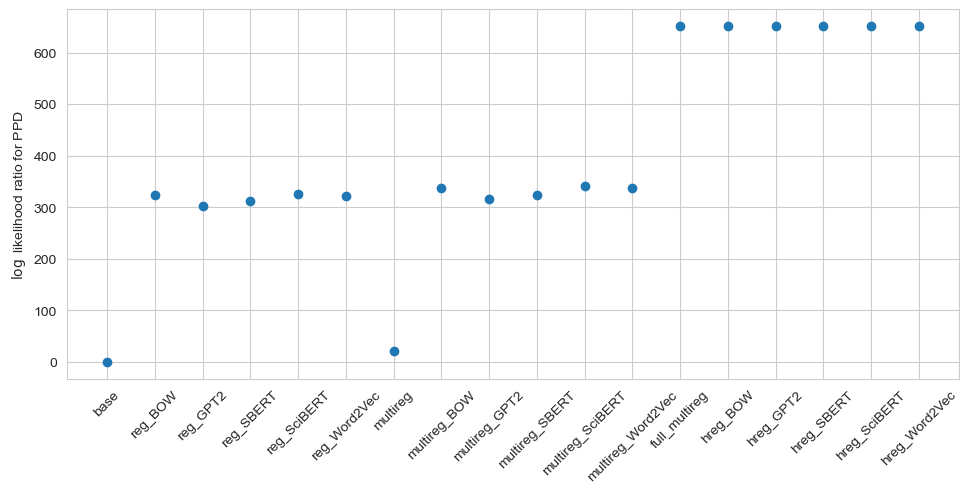

In [75]:
fig = plt.figure(figsize=(6.4 * len(results) / 10, 4.8))
ax = plt.gca()

x = np.arange(len(results))
ax.scatter(
    x,
    results["log_ppd"] - results.loc["base", "log_ppd"],
)

ax.set_xticks(x)
ax.set_xticklabels(results.index, rotation=45)

ax.set_ylabel(r"PPD $\log$ likelihood ratio")

### RMSE

In [67]:
beta_cols = [col for col in results.columns if col[:4] == "beta" and not "," in col]
betas = results[beta_cols].fillna(0.0)
x_cols = [col[5:-1] for col in beta_cols]
x_test = df_test[x_cols].fillna(0.0)

In [68]:
# Calculate y_pred
y_pred = np.matmul(x_test.values, betas.T)
y_pred += results["alpha"].values.reshape(1, -1)
y_pred.index = df_test.index
y_pred

,base,reg_BOW,reg_GPT2,reg_SBERT,reg_SciBERT,reg_Word2Vec,multireg,multireg_BOW,multireg_GPT2,multireg_SBERT,multireg_SciBERT,multireg_Word2Vec,full_multireg,hreg_BOW,hreg_GPT2,hreg_SBERT,hreg_SciBERT,hreg_Word2Vec
identifier,,,,,,,,,,,,,,,,,,
15df368fca57a9e0da636e17b42a0e506ef39ebf,0.03916,-0.071035,-0.005958,0.103360,-0.018144,-0.010710,-0.017635,-0.115689,-0.059405,0.019164,-0.045043,-0.065236,0.078856,0.078815,0.000082,0.047804,-0.014183,-0.027622
1325ad1682ed356282dae5c4c382693ccc871142,0.03916,-0.020793,0.066386,0.064324,-0.004564,-0.017276,0.138126,0.071072,0.153135,0.161288,0.064863,0.110895,0.106907,0.078815,0.000082,0.047804,-0.014183,-0.027622
f6c6d291aa4b8f3f661010d1ff3d10e8882aa6c9,0.03916,-0.089647,0.190964,0.064324,-0.015596,-0.001058,0.106330,-0.007490,0.237238,0.127932,0.073006,0.052296,0.326097,0.078815,0.000082,0.047804,-0.014183,-0.027622
622850aee3efb1623c577e9cc1f291853f3d8e17,0.03916,0.199391,0.133115,0.060441,-0.007592,-0.007882,-0.132343,-0.020826,-0.041208,-0.103669,-0.189621,-0.186170,0.067611,0.078815,0.000082,0.047804,-0.014183,-0.027622
59d343044169d5d890c335f062c0362b40f6c674,0.03916,-0.096360,0.007139,0.057101,-0.012459,-0.020092,0.024627,-0.109420,0.003012,0.068683,-0.037472,-0.019368,0.001591,0.078815,0.000082,0.047804,-0.014183,-0.027622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c717761eeeb5e7d641102a58a436c30ef12c7627,0.03916,-0.090662,0.184191,0.058868,-0.013874,0.009611,0.238748,0.101471,0.366639,0.272406,0.182159,0.157800,0.389570,0.078815,0.000082,0.047804,-0.014183,-0.027622
e75f9c44b7b8b3bb7901d9432917a1004cce4e06,0.03916,0.001644,0.187769,0.230965,-0.009146,-0.005122,-0.206401,-0.219396,-0.072295,-0.165672,-0.240137,-0.251837,0.182240,0.078815,0.000082,0.047804,-0.014183,-0.027622
f44df3f3443e31ba7dacab29ad55f2a5ca2bed1c,0.03916,0.001644,0.178109,0.162677,-0.009146,-0.005122,-0.072777,-0.086852,0.040594,-0.054039,-0.102530,-0.106414,0.215324,0.078815,0.000082,0.047804,-0.014183,-0.027622


In [69]:
# Calcualte rmse
results["rmse"] = y_pred.apply(lambda x: root_mean_squared_error(df_test["log_cpy"], x))

(0.0, 1.2590962664961607)

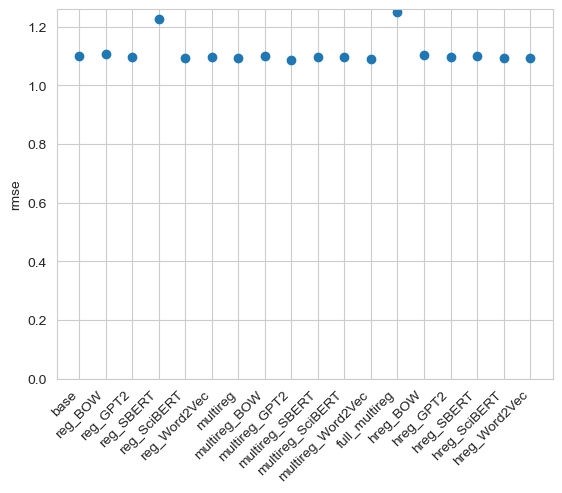

In [70]:
fig = plt.figure()
ax = plt.gca()

x = np.arange(len(results))
ax.scatter(
    x,
    results["rmse"],
)

ax.set_xticks(x)
ax.set_xticklabels(results.index, rotation=45, ha="right")
ax.set_ylabel("rmse")

ax.set_ylim(0, ax.get_ylim()[1])

### Maximum slopes

In [71]:
max_betas = results[beta_cols].max(axis="columns")

(0.0, 0.23214169525)

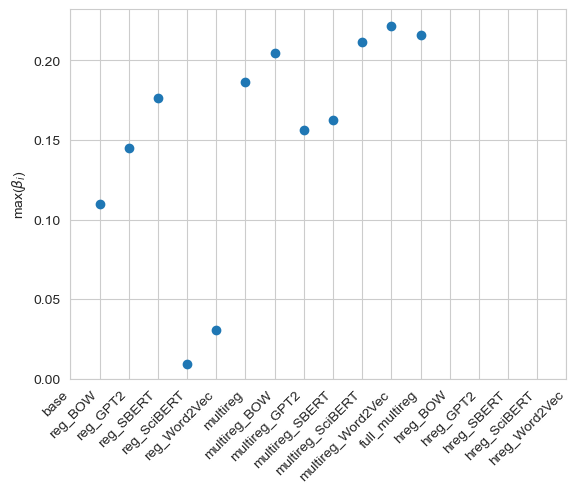

In [72]:
fig = plt.figure()
ax = plt.gca()

x = np.arange(len(results))
ax.scatter(
    x,
    max_betas,
)

ax.set_xticks(x)
ax.set_xticklabels(results.index, rotation=45, ha="right")
ax.set_ylabel(r"max($\beta_i$)")

ax.set_ylim(0, ax.get_ylim()[1])

Text(0, 0.5, '1 - rmse')

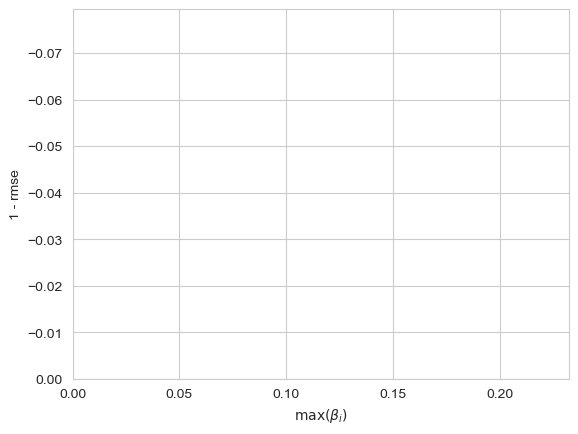

In [73]:
# max slopes correlation with rmse
ax = sns.scatterplot(
    results,
    x=max_betas,
    y=1 - results["rmse"],
)
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])

ax.set_xlabel(r"$\max(\beta_i)$")
ax.set_ylabel(r"1 - rmse")

### RMSE vs distance from center

In [ ]:
# Inspect rmse as a function of distance from the center
for model_i in results.index:

    row = results.loc[model_i]

    # Only do models that have a density dependence
    try:
        vectorizer_i = model_i.split("_")[-1]
        assert vectorizer_i in vectorizer_names
    except AssertionError:
        continue

    # Bin and labels setup
    bins = np.linspace(-3, 3, config["bins"])
    centers = 0.5 * (bins[:-1] + bins[1:])
    den_key = f"rho_{vectorizer_i}"
    cut_key = f"{den_key}_bin"
    model_key = f"y_pred_{model_i}"

    # Format data into a new df and group it
    df_test_to_group = pd.DataFrame()
    df_test_to_group[den_key] = df_test[vectorizer_i]
    df_test_to_group[model_key] = y_pred[model_i]
    df_test_to_group[cut_key] = pd.cut(df_test_to_group[den_key], bins)
    df_test_to_group["y_test"] = df_test["log_cpy"]
    df_grouped = df_test_to_group.groupby(cut_key)

    # Get mean predicted y per bin
    def get_mean_y_pred(df):
        if len(df) == 0:
            return np.nan
        return df[model_key].mean()

    mean_y_pred = df_grouped.apply(get_mean_y_pred)

    # Get rmse
    def get_rmse_of_df(df):
        if len(df) == 0:
            return np.nan
        return root_mean_squared_error(df["y_test"], df[model_key])

    rmse_per_bin = df_grouped.apply(get_rmse_of_df)

    # Also get rmse if y_pred was just the mean
    def get_rmse_from_mean(df):
        if len(df) == 0:
            return np.nan
        y_pred = np.zeros(len(df))  # Since we normalized to 0
        return root_mean_squared_error(df["y_test"], y_pred)

    rmse_from_mean = df_grouped.apply(get_rmse_from_mean)

    # And rmse expected if it was a straight improvement on the mean that scales with
    # slope
    min_rmse = rmse_from_mean - np.abs(centers * row[f"beta[{vectorizer_i}]"])

    # Plot
    fig, ax_dict = plt.subplot_mosaic(
        [
            [
                "hist",
            ],
            [
                "reg",
            ],
            [
                "reg",
            ],
            [
                "rmse",
            ],
            [
                "rmse",
            ],
        ],
        figsize=(8, 12),
    )

    # Hist plot
    ax = ax_dict["hist"]
    sns.histplot(
        x=df_test_to_group[den_key],
        ax=ax,
        bins=bins,
    )
    ax.set_xlim(bins[0], bins[-1])
    ax.set_title(model_i)
    ax.set_xlabel(None)

    # Regression plot
    ax = ax_dict["reg"]

    # Plot the median
    medianplot(
        data=df_test_to_group,
        x=den_key,
        y="y_test",
        bins=bins,
        ax=ax,
    )

    # Plot the regression
    xs = bins
    ys = row["alpha"] + row[f"beta[{vectorizer_i}]"] * xs
    ax.plot(
        xs,
        ys,
        color=palette[0],
    )
    ax.fill_between(
        xs,
        ys - row["sigma"],
        ys + row["sigma"],
        color=palette[0],
        alpha=0.25,
    )

    # Plot what y_pred actually is
    ax = sns.scatterplot(
        x=centers,
        y=mean_y_pred,
        ax=ax,
    )

    ax.set_xlabel(None)
    ax.set_ylabel("log_cpy")

    # RMSE plot
    ax = ax_dict["rmse"]
    ax = sns.scatterplot(
        x=centers,
        y=rmse_per_bin,
        ax=ax,
        label="rmse",
    )
    ax = sns.scatterplot(x=centers, y=rmse_from_mean, ax=ax, label="rmse(y_pred=0)")
    ax = sns.scatterplot(x=centers, y=min_rmse, ax=ax, label="min rmse")
    ax.legend()
    # Center line
    ax.axvline(
        0,
        c="0.2",
        linestyle="--",
    )
    # Global rmse line
    ax.axhline(
        results.loc[model_i, "rmse"],
        c="0.2",
        linestyle="--",
    )

    ax.set_ylabel("rmse")
    ax.set_xlabel(den_key)

    ax.set_xlim(bins[0], bins[-1])
    ax.set_ylim(0, ax.get_ylim()[1])
    fig

The issue is that RMSE is capturing two behaviors: distance from the mean and also width of the distribution.
The width of the distribution largely dominates over the distance from the mean.
So instead we may want a metric that is an evaluation of the distance median.
This might relate to Nathaniel's choice to bin.

## Many metrics

In [ ]:
metrics = {
    r"$R^2$": sk_metrics.r2_score,
    "1-MAE": lambda y_true, y_pred: 1 - sk_metrics.mean_absolute_error(y_true, y_pred),
    "1-RMSE": lambda y_true, y_pred: 1
    - sk_metrics.root_mean_squared_error(y_true, y_pred),
    "1-MAPE": lambda y_true, y_pred: 1
    - sk_metrics.mean_absolute_percentage_error(y_true, y_pred),
    "1-MedAE": lambda y_true, y_pred: 1
    - sk_metrics.median_absolute_error(y_true, y_pred),
    "1-MPinL": lambda y_true, y_pred: 1 - sk_metrics.mean_pinball_loss(y_true, y_pred),
    r"$D^2_{pin}$": sk_metrics.d2_pinball_score,
    r"$D^2_{abs}$": sk_metrics.d2_absolute_error_score,
}

In [ ]:
for metric_label, metric_fn in metrics.items():

    metric = y_pred.apply(lambda x: metric_fn(df_test["log_cpy"], x))

    # Plot
    fig = plt.figure()
    ax = plt.gca()

    x = np.arange(len(results))
    ax.scatter(
        x,
        metric,
    )

    ax.set_xticks(x)
    ax.set_xticklabels(results.index, rotation=45, ha="right")
    ax.set_ylabel(metric_label)